In [2]:
import sys
sys.path.append('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/codes/')
from module.strategy import *
from itertools import chain
import nonlinshrink as nls
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS
from scipy.stats import moment
import numpy as np
import pandas as pd
from module.backtesting_old import vectorized_backtesting
from module.data_handler import data_handler
import matplotlib.pyplot as plt

# Shrinkage intensity analysis
A compare between in-sample optimal shrinkage intensity and the one of estimator from ledoit shrinkage and RL\
 is benificial to look deeper into the performance of different estimators.

## Optimal in-sample alpha

In [2]:
class shrink_fixed_alpha_in_sample(vectorized_backtesting):
    '''
    Shrink sample covariance matrix a fixed percent to identity matrix
    '''
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.stock_num = self.covariance_aggregate.shape[1]

    def get_portfolio(self, year):
        sample_covariance_matrix = self.stocks_returns_aggregate.loc[year-1: year - 1].cov()
        covariance_shrunk = self.get_shrank_cov(covariance_matrix=sample_covariance_matrix.values,\
                                                shrink_target=np.identity(self.stock_num),\
                                                a=self.alpha)
        portfolio = self.get_GMVP(covariance_matrix = covariance_shrunk)
        return portfolio

In [3]:
def get_optimal_in_sample_alpha_and_SR(year:int, alpha_step:float = 0.01) -> tuple:
    '''
    Perform in-sample analysis to find out the optimum shrinkage intensity for current year.
    Use current year's stock return construct covariance matrix.
    Then backtest it on the same year (current year).
    The optimal alpha is an infeasible estimator, since the estimation of current year shrinkage intensity 
    is always generated from previous year's data.
    '''
    alpha_range = np.arange(start=0, stop=1+alpha_step, step=alpha_step)
    alpha_strategy_list = [shrink_fixed_alpha_in_sample(alpha=alpha) for alpha in alpha_range]
    strategy_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy in alpha_strategy_list]
    SR_performance_list = [strategy.get_sharpe_ratio() for strategy in alpha_strategy_list]
    alpha_optimum_idx = np.argmax(SR_performance_list)
    alpha_optimum = alpha_optimum_idx*alpha_step
    SR_optimum = SR_performance_list[alpha_optimum_idx]

    # visulization
    fig = plt.figure(figsize=(6, 3))
    plt.plot(alpha_range, SR_performance_list, label = year)
    plt.ylabel('Sharpe ratio')
    plt.xlabel('Shrinkage intensity')
    plt.legend()
    plt.close(fig)

    return (alpha_optimum, SR_optimum, fig)


In [4]:
year_range = np.arange(2001, 2017+1)
alpha_optimum_list, SR_optimum_list, fig_list = zip(*[get_optimal_in_sample_alpha_and_SR(year = year, alpha_step = 0.01) for year in year_range])

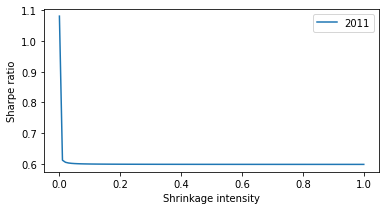

In [29]:
fig_list[10]

## RL estimation

In [4]:
year_range = np.arange(2001, 2017+1)
file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/table/DQN_performance.csv'
dqn_perfromance_df = pd.read_csv(file_path, header=0)
rl_alpha_list = dqn_perfromance_df['action']
dqn_perfromance_df.index = year_range

In [17]:
class shrink_fixed_alpha_identity(vectorized_backtesting):
    '''
    Shrink sample covariance matrix a fixed percent to identity matrix
    '''
    def __init__(self):
        super().__init__()
        self.alpha_mapping = dqn_perfromance_df['action']
        self.stock_num = self.covariance_aggregate.shape[1]

    def get_portfolio(self, year):
        sample_covariance_matrix = self.stocks_returns_aggregate.loc[year-1: year - 1].cov()
        covariance_shrunk = self.get_shrank_cov(covariance_matrix=sample_covariance_matrix.values,\
                                                shrink_target=np.identity(self.stock_num),\
                                                a=self.alpha_mapping[year])
        portfolio = self.get_GMVP(covariance_matrix = covariance_shrunk)
        return portfolio

In [14]:
class shrink_fixed_alpha_tbn(vectorized_backtesting):
    '''
    Shrink sample covariance matrix a fixed percent to TBN
    '''
    def __init__(self):
        super().__init__()
        self.alpha_mapping = dqn_perfromance_df['action']

    def get_portfolio(self, year):
        covariance_shrunk = self.get_shrank_cov(correlation_matrix=self.correlation_aggregate.loc[year - 1].values,\
                                                shrink_target=self.tbn_combined.loc[year - 1].values,\
                                                volatility_vector=self.volatility_aggregate.loc[year - 1].values,
                                                a=0.5)
        portfolio = self.get_GMVP(covariance_matrix = covariance_shrunk)
        return portfolio

In [22]:
dqn_perfromance_df['reward']

2001   -0.234505
2002   -0.571951
2003    1.858682
2004    0.979907
2005   -0.484751
2006    1.307949
2007    0.579177
2008   -0.586461
2009    0.585745
2010    0.423904
2011    0.851355
2012    0.007403
2013    2.535650
2014    0.968755
2015   -0.048683
2016    0.899404
2017    3.030748
Name: reward, dtype: float64

In [23]:
rl_agent_list = [shrink_fixed_alpha_tbn() for _ in year_range]
rl_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(rl_agent_list, year_range)]
rl_SR_list = [strategy.get_sharpe_ratio() for strategy in rl_agent_list]

## Ledoit estimation

In [30]:
class Linear_shrink_ledoit(vectorized_backtesting):
    '''
    Linear shrinkage method(ledoit) that shrink to identity matrix
    '''
    def __init__(self):
        super().__init__()
        self.shrinkage = None
        #self.stock_num = self.covariance_aggregate.shape[1]
        
    def get_portfolio(self, year):
        self.shrinkage = LedoitWolf().fit(self.stocks_returns_aggregate.loc[year-1:year - 1]).shrinkage_
        covariance_shrunk = LedoitWolf().fit(self.stocks_returns_aggregate.loc[year-1:year - 1]).covariance_
        portfolio = self.get_GMVP(covariance_matrix=  covariance_shrunk)
        return portfolio

In [31]:
year_range = np.arange(2001, 2017+1)
ledoit_agent_list = [Linear_shrink_ledoit() for _ in year_range]
strategy_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(ledoit_agent_list, year_range)]
SR_performance_list = [strategy.get_sharpe_ratio() for strategy in ledoit_agent_list]
ledoit_alpha_list = [strategy.shrinkage for strategy in ledoit_agent_list]

## Performance data aggragation

In [32]:
alpha_df = pd.DataFrame()
alpha_df['optimal shrinkage intensity'] = alpha_optimum_list
alpha_df['Ledoit estimation'] = ledoit_alpha_list
alpha_df['RL estimation'] = rl_alpha_list
alpha_df.index = year_range

In [33]:
SR_df = pd.DataFrame()
SR_df['optimal Sharpe ratio'] = SR_optimum_list
SR_df['Ledoit shrinkage'] = SR_performance_list
SR_df['RL shrinkage'] = rl_SR_list
SR_df.index = year_range

## Display and output

### Shrinkage intensity

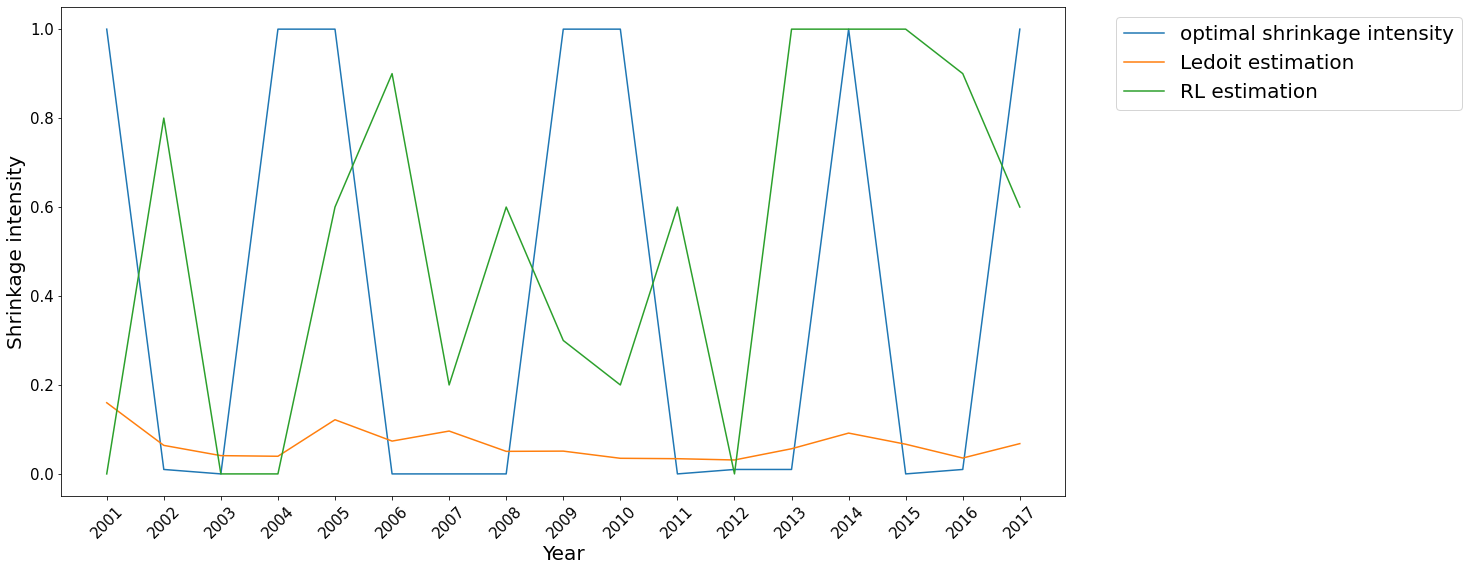

In [15]:
plot = alpha_df.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'Shrinkage intensity',
                    fontsize=15,
                    figsize = (18, 9),
                    xticks = year_range,
                    rot = 45)
plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})

In [25]:
# output plot to DB
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Portfolio Selection via Text Based Network/picture/'
file_name = 'Shrinkage intensity in-sample analysis'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)

In [159]:
# output latex table to DB
dh = data_handler()
table_name = 'Shrinkage intensity in-sample analysis'
caption = 'This table repots the shrinkage intensity of in-sample optimum, Ledoit and Wold linear shrinkage estimator and RL estimator.\
           The considering period is 2001 to 2017. '
label = 'tbl:alpha in sample'
dh.export_dataframe_to_latex_table(alpha_df,
                                    table_name=table_name,
                                    float_format='%.2f',
                                    caption=caption,
                                    label=label)

### Sharpe ratio

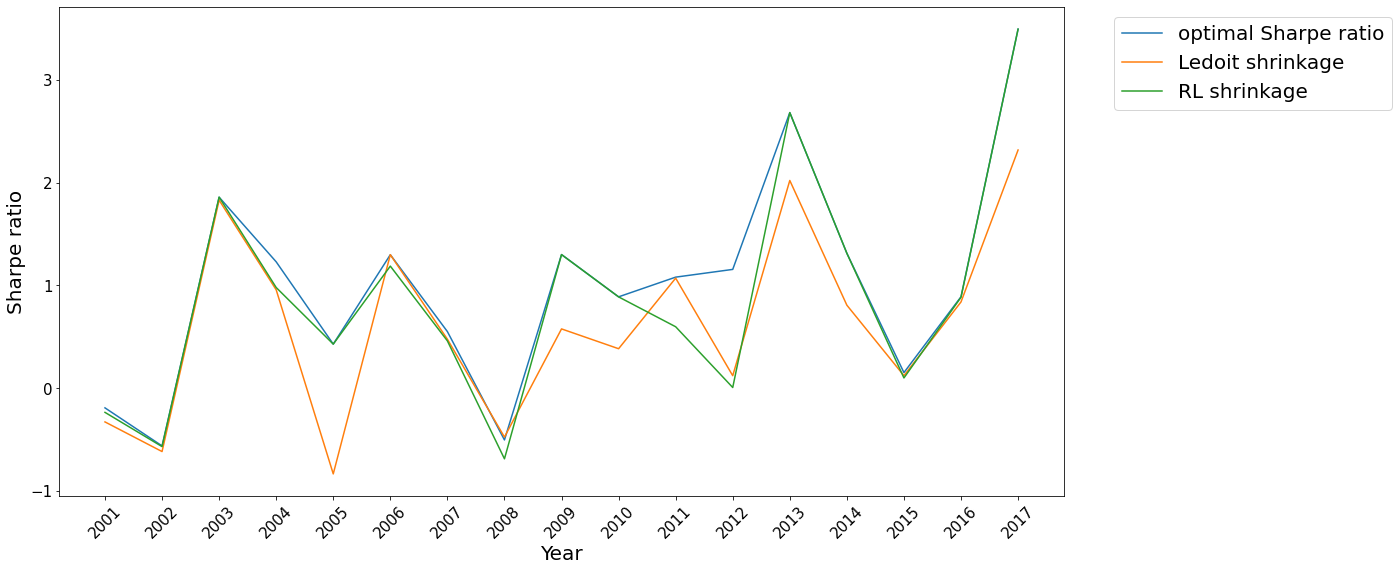

In [41]:
plot = SR_df.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'Sharpe ratio',
                    figsize = (18, 9),
                    xticks = year_range,
                    fontsize = 15,
                    rot = 45)
plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})

In [42]:
# output plot to DB
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Portfolio Selection via Text Based Network/picture/'
file_name = 'Sharpe ratio in-sample analysis'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)

In [43]:
# output latex table to DB
dh = data_handler()
table_name = 'Sharpe ratio in-sample analysis'
caption = 'This table repots the Sharpe ratio of in-sample optimum, Ledoit and Wold linear shrinkage estimator and RL estimator.\
           The considering period is 2001 to 2017. '
label = 'tbl:SR in sample'
dh.export_dataframe_to_latex_table(SR_df,
                                    table_name=table_name,
                                    float_format='%.3f',
                                    caption=caption,
                                    label=label)

## Plot with VIX

In [46]:
# load VIX monthly data
file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/data/Data/vix.csv'
vix = pd.read_csv(file_path, header=0, index_col=0)
vix.index = np.repeat(np.arange(2001, 2018), 12)
vix_close_annual = vix.groupby(level=0).mean()['VIX.Close']

### Sharpe ratio with VIX

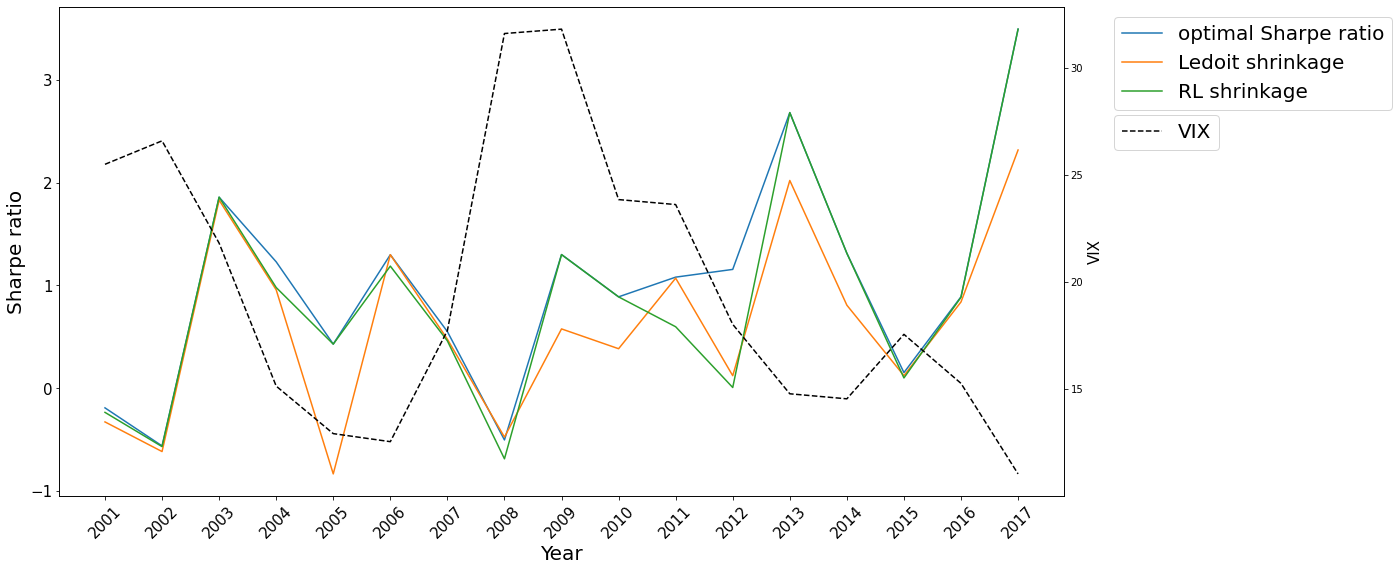

In [79]:
plot = SR_df.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'Sharpe ratio',
                    figsize = (18, 9),
                    xticks = year_range,
                    fontsize = 15,
                    rot = 45)
plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})
ax2=plot.twinx()
ax2.plot(vix_close_annual, label='VIX', linestyle='dashed', color = 'k')
ax2.set_ylabel('VIX', fontsize=15)
ax2.legend(bbox_to_anchor=(1.04,0.8), loc="upper left", prop={'size': 20})

In [74]:
# output plot to DB
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Portfolio Selection via Text Based Network/picture/'
file_name = 'Sharpe ratio in-sample analysis with VIX'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)

### Shrinkage intensity with VIX

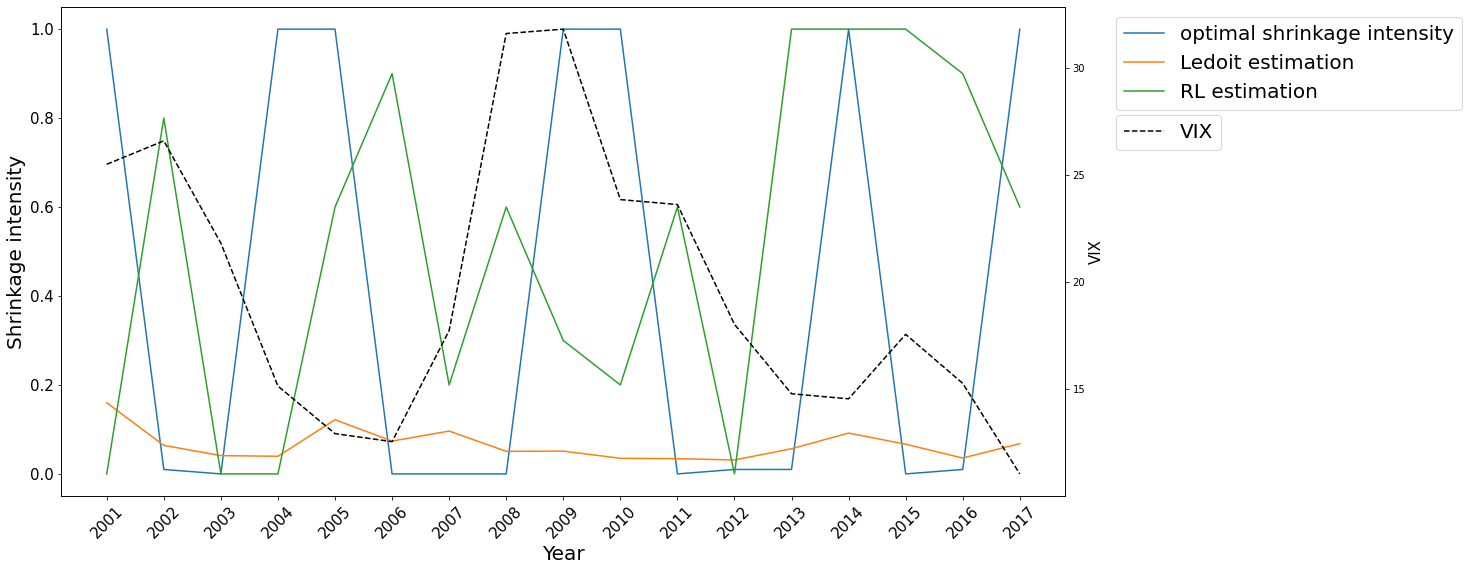

In [77]:
plot = alpha_df.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'Shrinkage intensity',
                    fontsize=15,
                    figsize = (18, 9),
                    xticks = year_range,
                    rot = 45)
plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})
ax2=plot.twinx()
ax2.plot(vix_close_annual, label='VIX', linestyle='dashed', color = 'k')
ax2.set_ylabel('VIX', fontsize=15)
ax2.legend(bbox_to_anchor=(1.04,0.8), loc="upper left", prop={'size': 20})

In [78]:
# output plot to DB
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Portfolio Selection via Text Based Network/picture/'
file_name = 'Shrinkage intensity in-sample analysis with VIX'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)